In [1]:
import numpy as np
import tensorflow.keras as keras
from scipy import stats
from scipy.spatial.distance import cosine
import seaborn as sns
import pickle
from clseacher import clseacher as cl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# MNIST датасет

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
print(f"train: {int(len(x_train) * 0.9)}, validation: {int(len(x_train) * 0.1)}, test: {len(x_test)}")

train: 54000, validation: 6000, test: 10000


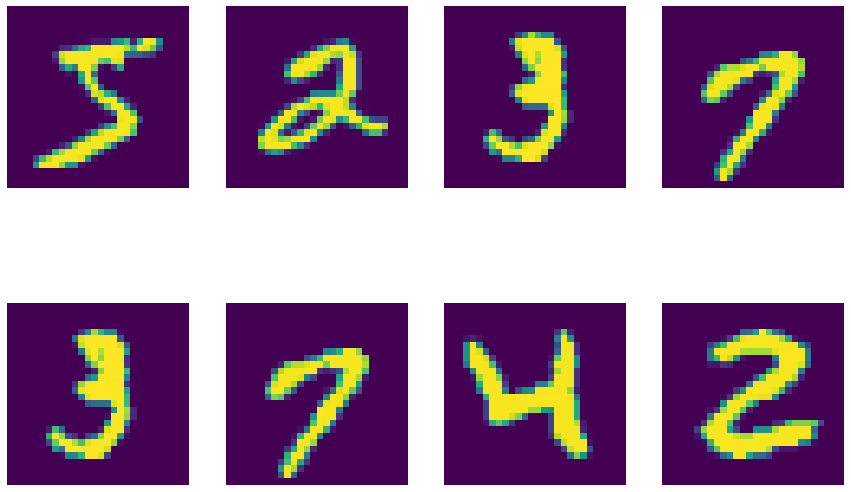

In [3]:
fig, ax = plt.subplots(2,4, figsize=(15,10))
for i in range(2):
    for j in range(4):
        ax[i,j].imshow(x_train[i*10 + j * 5, :, :, 0])
        ax[i,j].set_axis_off()
plt.show()

# Базовая модель

In [4]:
model = keras.Sequential(
    [
        keras.Input(shape=x_train.shape[1:]),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation="softmax"),
    ]
)
batch_size = 128
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", keras.metrics.AUC()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                3

# Использование класса поиска

1. Необходимо инициализировать класс с помощью вызова конструктора, передать: базовую модель, форму входного тензора, метрику

In [5]:
seacher = cl(model, x_train.shape[1:], keras.metrics.AUC, lang='ru')

2. Запуск поиска

In [6]:
seacher.search(
    (x_train, y_train, x_test, y_test),
    epochs = 15,
    batch_size = 2048,
    save_path_folder = "example_path",
    eq_type = True, 
    A = 0.999,
    alpha = 0.1,
    p_value = 0.005,
    print_iter = True
)

Итерация   | Совокупно отсеяно  | Количество параметров  | Метрика              |
1          | 84                 | 23538                  | 0.999723             |
2          | 44                 | 3948                   | 0.998537             |
Поиск завершен, метрика не удовлетворяет критерию А: 0.999 > 0.998537


# Доступ к истории поиска
1. История метрик

In [7]:
seacher.track_metric

[0.9998258948326111, 0.9997225999832153, 0.9985365867614746]

2. Информация об архитектуре на каждом шаге

In [8]:
seacher.steps

[{'cl_1': 64, 'cl_2': 128}, {'cl_1': 52, 'cl_2': 32}, {'cl_1': 38, 'cl_2': 6}]